In [1]:
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='poster')

In [2]:
with open('results/01_compare_baseline_models.pickle', 'rb') as f:
    svc_results, log_reg_results, random_forest_results, evaluated_datasets, baseline_times = pickle.load(f)
    
database = pd.read_json("database.json").T
database.loc[:, 'nrow'] = np.minimum(10000, database['nrow'])

with open('results/02_lightgbm_n_iter_10.pickle', 'rb') as f:
    lightgbm_10_results, lgb_10_times = pickle.load(f)
    
with open('results/02_lightgbm_n_iter_25.pickle', 'rb') as f:
    lightgbm_25_results, lgb_25_times = pickle.load(f)
    
with open('results/03_autogluon_sec_60.pickle', 'rb') as f:
    autogluon_60s_results, autogluon_60s_times = pickle.load(f)
    
with open('results/03_autogluon_sec_120.pickle', 'rb') as f:
    autogluon_120s_results, autogluon_60s_times = pickle.load(f)

In [3]:
svc_df = pd.DataFrame(svc_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
svc_df['model'] = 'SVC'
log_reg_df = pd.DataFrame(log_reg_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
log_reg_df['model'] = 'Logistic Regression'
random_forest_df = pd.DataFrame(random_forest_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
random_forest_df['model'] = 'Random Forest'
lightgbm_10_df = pd.DataFrame(lightgbm_10_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
lightgbm_10_df['model'] = 'LightGBM (n_iter=10)'
lightgbm_25_df = pd.DataFrame(lightgbm_25_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
lightgbm_25_df['model'] = 'LightGBM (n_iter=25)'
autogluon_60s_df = pd.DataFrame(autogluon_60s_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
autogluon_60s_df['model'] = 'AutoGluon (sec=60)'
autogluon_120s_df = pd.DataFrame(autogluon_120s_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
autogluon_120s_df['model'] = 'AutoGluon (sec=120)'

In [4]:
results_df = pd.concat([svc_df, log_reg_df, random_forest_df, lightgbm_10_df, lightgbm_25_df, autogluon_60s_df, autogluon_120s_df], axis=0)
results_df.columns = ['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4', 'model']
results_df = results_df.join(database, how='left')
results_df['mean_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].mean(1)
results_df['min_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].min(1)
results_df['max_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].max(1)
results_df['std_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].std(1)
results_df['dataset'] = results_df.index

In [5]:
# how often each one is best.
# anything within 0.5% of the best counts as a tie and gets full credit
winning_algorithms = []
for dataset in evaluated_datasets:
    df_sub = results_df.loc[dataset]
    highest_auroc = df_sub['mean_auroc'].max()
    winning_algorithms.extend(df_sub.loc[df_sub['mean_auroc'] >= highest_auroc * 0.995, 'model'])

print('Number of datasets each algorithm does best on:')
print(Counter(winning_algorithms), '\n')
print('Average performance for each', results_df.groupby('model')['mean_auroc'].mean(), '\n')
print('Median performance for each', results_df.groupby('model')['mean_auroc'].median())

Number of datasets each algorithm does best on:
Counter({'AutoGluon (sec=120)': 84, 'AutoGluon (sec=60)': 74, 'LightGBM (n_iter=25)': 74, 'LightGBM (n_iter=10)': 68, 'Random Forest': 65, 'Logistic Regression': 64, 'SVC': 56}) 

Average performance for each model
AutoGluon (sec=120)     0.887491
AutoGluon (sec=60)      0.886326
LightGBM (n_iter=10)    0.886359
LightGBM (n_iter=25)    0.888885
Logistic Regression     0.857380
Random Forest           0.886253
SVC                     0.863614
Name: mean_auroc, dtype: float64 

Median performance for each model
AutoGluon (sec=120)     0.924359
AutoGluon (sec=60)      0.925754
LightGBM (n_iter=10)    0.924920
LightGBM (n_iter=25)    0.927121
Logistic Regression     0.891617
Random Forest           0.922966
SVC                     0.891575
Name: mean_auroc, dtype: float64


<AxesSubplot:xlabel='mean_auroc', ylabel='model'>

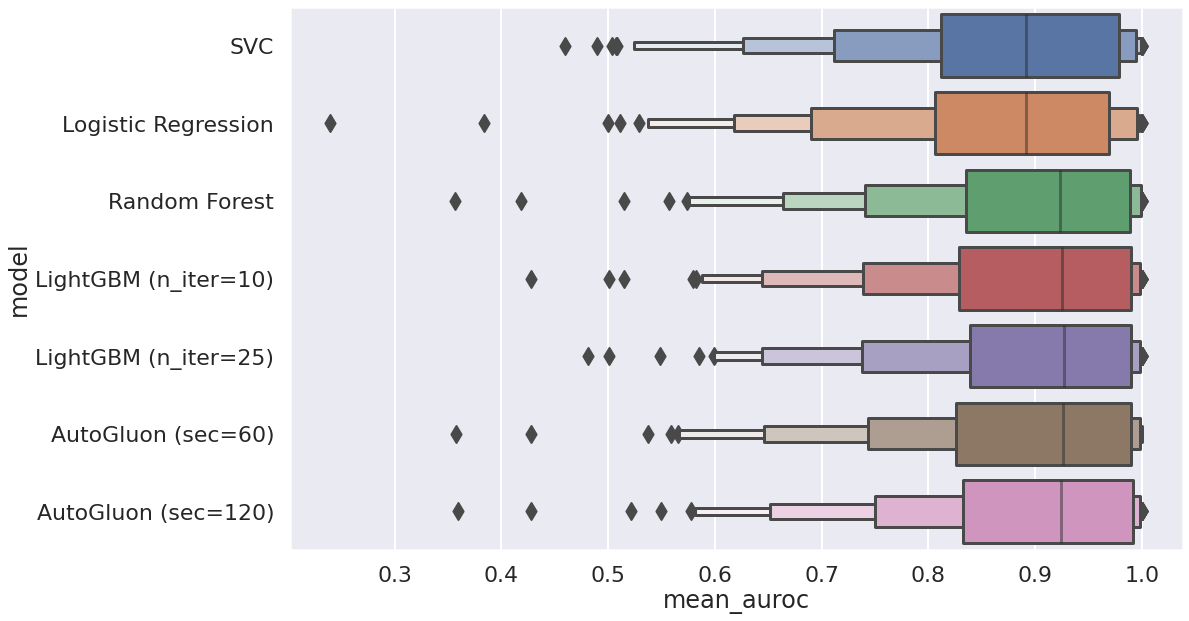

In [6]:
# distributions of each algorithm's mean aurocs
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)
sns.boxenplot(data=results_df, x="mean_auroc", y='model', ax=ax)

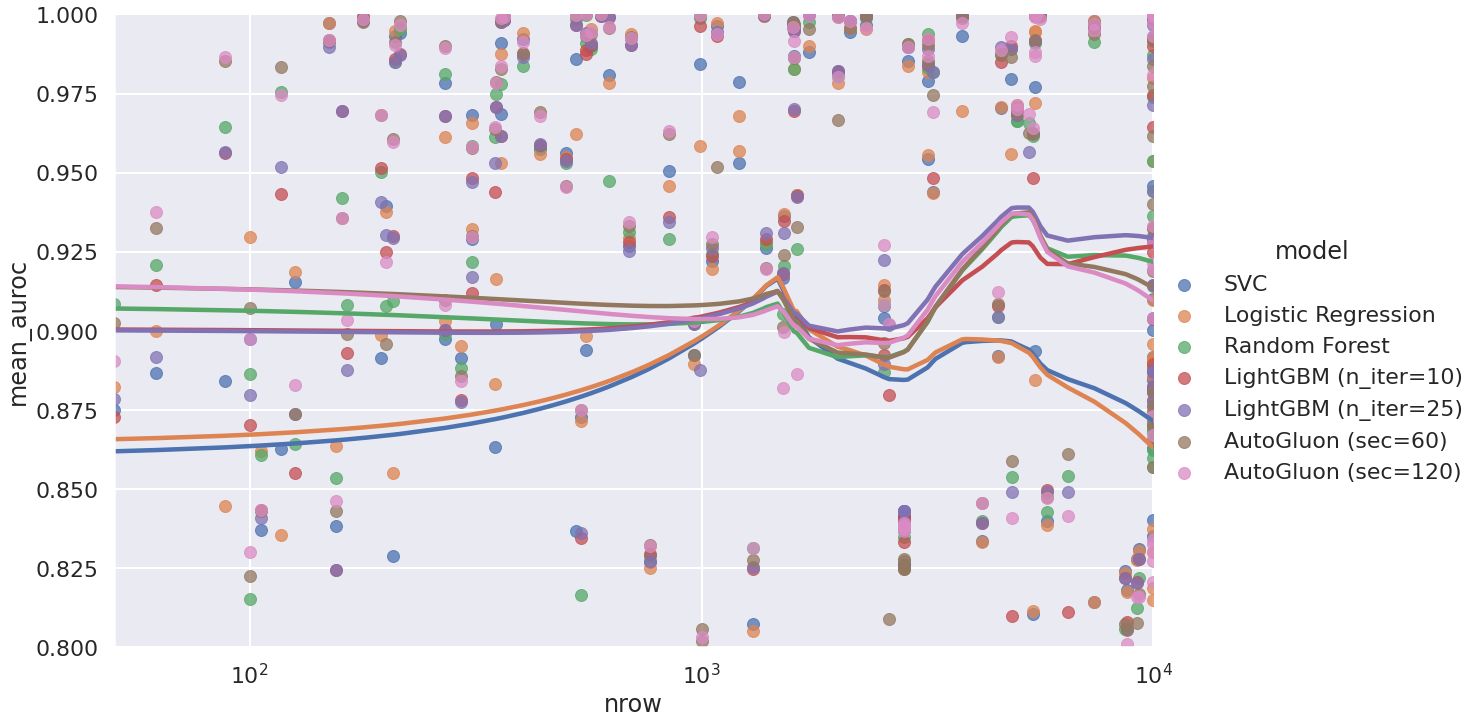

In [7]:
# mean auroc vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="mean_auroc",
    hue="model",
    lowess=True,
    height=10,
    aspect=1.6,
    scatter_kws={'alpha': 0.75}
)
g.set(ylim=[0.8, 1.0])
g.set(xscale="log")

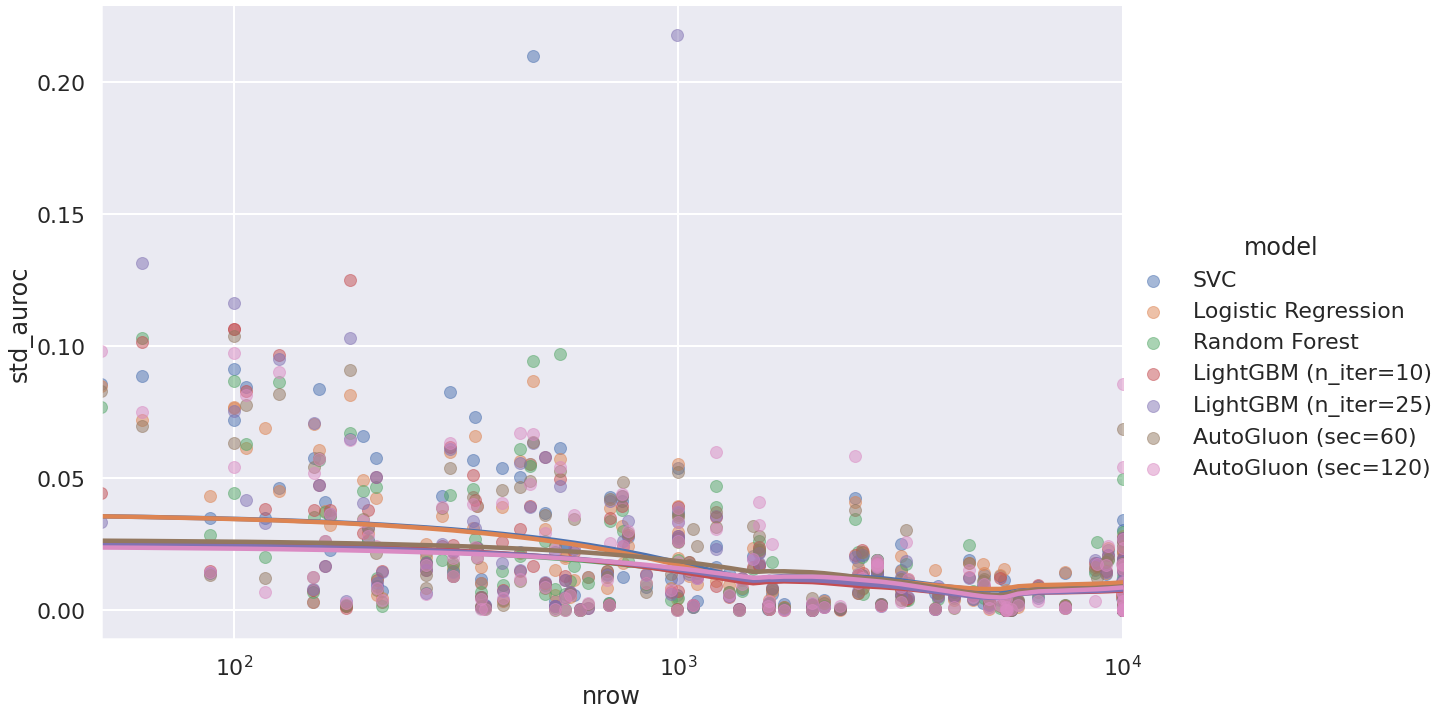

In [8]:
# standard deviation of auroc (across folds) vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="std_auroc",
    hue="model",
    lowess=True,
    height=10, 
    aspect=1.6,
    scatter_kws={'alpha': 0.5}
)
g.set(xscale="log")

In [9]:
# datasets where there is a big gap between first largest and second largest performance
results_df.groupby('dataset')['mean_auroc'].apply(lambda x: np.sort(x)[-1] - np.sort(x)[-2]).sort_values()[-10:]

dataset
blogger                      0.007353
robot-failure-lp4            0.007863
habermans-survival           0.009707
hepatitis                    0.010181
hill-valley-without-noise    0.010784
thoracic-surgery             0.014894
leukemia-haslinger           0.022436
autoUniv-au7-cpd1-500        0.022964
planning-relax               0.114146
meta-data                    0.335800
Name: mean_auroc, dtype: float64

In [22]:
# interesting datasets: meta-data, planning-relax, blogger, autoUniv-au7-cpd1-500, leukemia-haslinger, thoracic-surgery, hill-valley-without-noise, blogger
results_df.loc['connectionist-vowel']

,auroc_split_1,auroc_split_2,auroc_split_3,auroc_split_4,model,nrow,ncol,mv,ir,class,mean_auroc,min_auroc,max_auroc,std_auroc,dataset
connectionist-vowel,0.989168,0.979898,0.978576,0.989061,SVC,990.0,14.0,0.0,0.090909,11.0,0.984176,0.978576,0.989168,0.005729,connectionist-vowel
connectionist-vowel,0.962657,0.953214,0.960909,0.957383,Logistic Regression,990.0,14.0,0.0,0.090909,11.0,0.958541,0.953214,0.962657,0.004174,connectionist-vowel
connectionist-vowel,0.998838,0.998621,0.998387,0.999406,Random Forest,990.0,14.0,0.0,0.090909,11.0,0.998813,0.998387,0.999406,0.000436,connectionist-vowel
connectionist-vowel,0.996457,0.997028,0.995780,0.996505,LightGBM (n_iter=10),990.0,14.0,0.0,0.090909,11.0,0.996443,0.995780,0.997028,0.000512,connectionist-vowel
connectionist-vowel,0.561180,0.997013,0.995780,0.996505,LightGBM (n_iter=25),990.0,14.0,0.0,0.090909,11.0,0.887619,0.561180,0.997013,0.217627,connectionist-vowel
connectionist-vowel,0.999374,0.999606,0.999748,0.999676,AutoGluon (sec=60),990.0,14.0,0.0,0.090909,11.0,0.999601,0.999374,0.999748,0.000162,connectionist-vowel
connectionist-vowel,0.999392,0.999893,0.999946,0.999711,AutoGluon (sec=120),990.0,14.0,0.0,0.090909,11.0,0.999735,0.999392,0.999946,0.000250,connectionist-vowel


In [23]:
# datasets where lightgbm with 25 evals does worse than 10 evals
results_df.groupby('dataset').apply(lambda x: x[x.model == 'LightGBM (n_iter=25)']['mean_auroc'] - x[x.model == 'LightGBM (n_iter=10)']['mean_auroc']).sort_values()[0:10]

dataset                                                                 
connectionist-vowel                  connectionist-vowel                   -0.108823
blogger                              blogger                               -0.062500
colon32                              colon32                               -0.022917
hill-valley-with-noise               hill-valley-with-noise                -0.021507
parkinsons                           parkinsons                            -0.010714
bupa                                 bupa                                  -0.009703
autoUniv-au7-300-drift-au7-cpd1-800  autoUniv-au7-300-drift-au7-cpd1-800   -0.008352
volcanoes-b5                         volcanoes-b5                          -0.005339
robot-failure-lp5                    robot-failure-lp5                     -0.005209
habermans-survival                   habermans-survival                    -0.005079
Name: mean_auroc, dtype: float64